In [2]:
import copy
import os
import random
import time
import csv
import ast
import cv2
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
import torchvision.transforms as transform
from torchvision.utils import make_grid
from torch import nn
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision.datasets import ImageFolder

from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Variable Initialization for Alzheimer's Disease Image Classification

`ALZHEIMER_DATA`: This variable contains the file path for the Alzheimer's disease dataset that the researcher will be working with.

`SAVE_PATH`: This variable contains the file path for the location where the researcher wants to save the output of their work, such as trained models, plots, and reports.

`IMG_HEIGHT`: This variable contains the desired height of the images that will be processed in the notebook.

`IMG_WIDTH`: This variable contains the desired width of the images that will be processed in the notebook.

`BATCH_SIZE`: This variable contains the number of images that will be processed at once during the training of the model.

These variables will be used later in the notebook, likely for data preprocessing and training the model.

In [3]:
ALZHEIMER_DATA = '/datasets/alzheimer/alzheimer/alzheimer_dataset'
SAVE_PATH = '/notebooks'
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64

# Visualizing Training Set Data Imbalance with a Bar Plot
This code creates a pandas DataFrame, train_samplesize, that contains the number of images in each class of the Alzheimer's disease training set. It then uses the seaborn library to create a bar plot of the data to visualize the imbalance in the training set. The title of the plot is "Training Set Data Imbalance", with a font size of 20. Finally, the plot is displayed using plt.show().

Based on the dataset provided, it is clear that there is a significant imbalance in the number of samples in each class of the Alzheimer's disease dataset. The "Non" class has the most samples, with ~2500 images, while the "Moderate" class has the fewest samples, with only ~200 images. The "Mild" and "VeryMild" classes have ~750 and ~2250 images respectively.

This class imbalance can be problematic when training a machine learning model, as the model may become biased towards the majority class and perform poorly on the minority classes. Therefore, it is important to address this imbalance before training the model. This can be done using techniques such as oversampling or undersampling, where the minority classes are either replicated or reduced, respectively, to balance the dataset. Other techniques such as data augmentation can also be used to generate additional samples for the minority classes.

In conclusion, the given dataset highlights the need to address class imbalance in the Alzheimer's disease dataset to improve the performance of machine learning models trained on it. The techniques mentioned above can be employed to balance the dataset and reduce the risk of bias towards the majority class.

/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


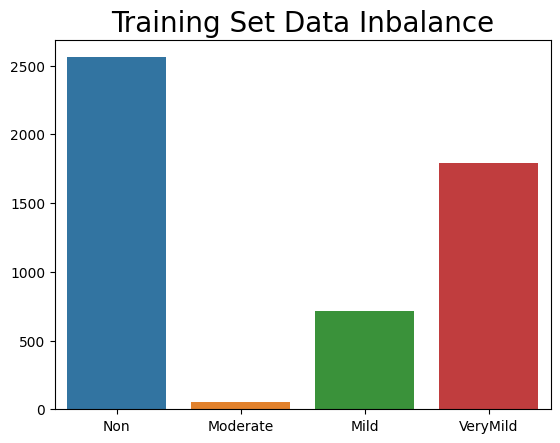

In [4]:
train_samplesize = pd.DataFrame.from_dict({
    'Non': [len([os.path.join(ALZHEIMER_DATA + '/train/NonDemented', filename) for filename in
                 os.listdir(ALZHEIMER_DATA + '/train/NonDemented')])],
    'Moderate': [len([os.path.join(ALZHEIMER_DATA + '/train/ModerateDemented', filename) for filename in
                      os.listdir(ALZHEIMER_DATA + '/train/ModerateDemented')])],
    'Mild': [len([os.path.join(ALZHEIMER_DATA + '/train/MildDemented', filename) for filename in
                  os.listdir(ALZHEIMER_DATA + '/train/MildDemented')])],
    'VeryMild': [len([os.path.join(ALZHEIMER_DATA + '/train/VeryMildDemented', filename) for filename in
                      os.listdir(ALZHEIMER_DATA + '/train/VeryMildDemented')])],
})

sns.barplot(data=train_samplesize).set_title('Training Set Data Inbalance', fontsize=20)
plt.show()


# Data Transformation and Dataset Creation
This section of code defines a dictionary of data transformations for the Alzheimer's disease dataset, which are used to augment the training data and improve the performance of the machine learning model. The transformers dictionary contains six different transformations, each defined using the transform.Compose() method. These transformations include resizing, rotating, flipping, and normalizing the images.

After defining the data transformations, the code creates an ImageFolder dataset using the train directory of the Alzheimer's disease dataset and applies the train_1 transformation from the transformers dictionary to the dataset. The ImageFolder class is a PyTorch class that is used to create datasets from image folders, where each subfolder contains images of a specific class.

Lastly, the code prints the names of the classes in the train_dataset using the classes attribute of the dataset.

In [5]:
transformers = {
    'train_1': transform.Compose([
        transform.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transform.RandomRotation(10),
        transform.ToTensor(),
        transform.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
    'train_2': transform.Compose([
        transform.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transform.RandomHorizontalFlip(),
        transform.ToTensor(),
        transform.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
    'train_3': transform.Compose([
        transform.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transform.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(3.0/4.0, 4.0/3.0)),
        transform.ToTensor(),
        transform.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
    'train_4': transform.Compose([
        transform.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transform.RandomRotation(5),
        transform.ToTensor(),
        transform.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
    'train_5': transform.Compose([
        transform.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transform.RandomHorizontalFlip(),
        transform.RandomRotation(5),
        transform.ToTensor(),
        transform.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
    'val': transform.Compose([
        transform.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transform.RandomGrayscale(),
        transform.ToTensor(),
        transform.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
}



In [6]:
train_dataset = ImageFolder(ALZHEIMER_DATA+'/train', transform=transformers['train_1'])

# Duplicate the dataset with different transforms
# duplicated_datasets = []
# for i in range(4):
#     dataset = ImageFolder(ALZHEIMER_DATA+'/train', transform=transformers[f'train{i+1}'])
#     duplicated_datasets.append(dataset)

In [7]:
classes = train_dataset.classes
classes

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Function for plotting training set samples

This section defines a function named plot_samples which takes in a list of image file paths as input and plots a 4x5 grid of sample images. The function first creates a subplot with 4 rows and 5 columns and sets the figure size to (10,8). It then loops through each image file path in the input list, reads the image using cv2.imread function and converts the color space from BGR to RGB using cv2.cvtColor. It then sets the title of the subplot based on the class of the image (Normal, Moderate, Mild, or VeryMild) and displays the image with the imshow function. Finally, it turns off the axis and shows the plot.

The code creates a list of 20 random image file paths from the training set, with 5 images from each class (Normal, Moderate, Mild, and VeryMild). It then passes this list to the plot_samples function to display a 4x5 grid of sample images from the training set. The title of the plot is set to "Training Set Samples" with a font size of 30 using plt.suptitle.

In [8]:
# Function for plotting samples
def plot_samples(samples):
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(10, 8))
    for i in range(len(samples)):
        image = cv2.cvtColor(plt.imread(samples[i]), cv2.COLOR_BGR2RGB)
        ax[i // 5][i % 5].imshow(image)
        if i < 5:
            ax[i // 5][i % 5].set_title("Normal", fontsize=20)
        elif i < 10:
            ax[i // 5][i % 5].set_title("Moderate", fontsize=20)
        elif i < 15:
            ax[i // 5][i % 5].set_title("Mild", fontsize=20)
        else:
            ax[i // 5][i % 5].set_title("VeryMild", fontsize=20)
        ax[i // 5][i % 5].axis('off')


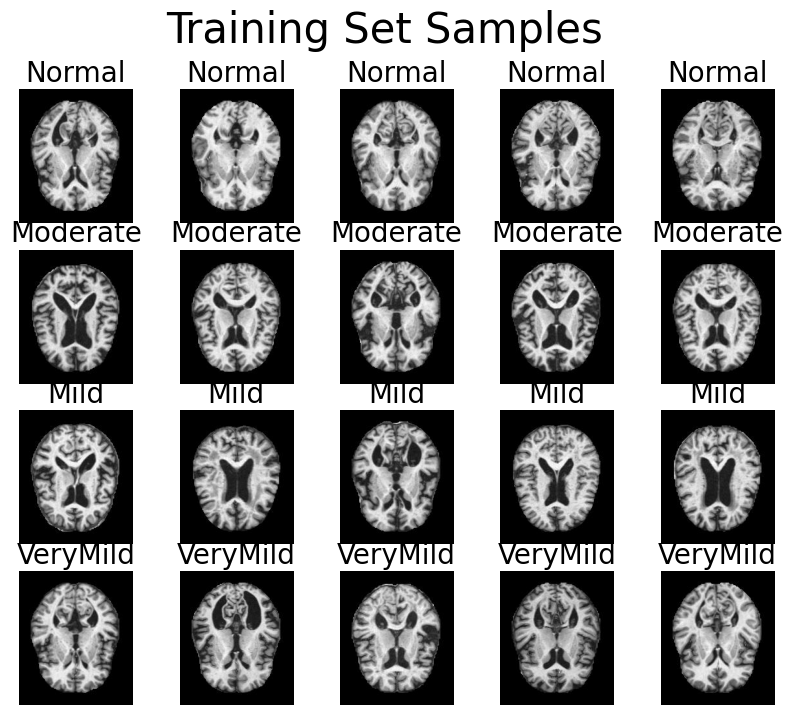

In [9]:
rand_samples = random.sample([os.path.join(ALZHEIMER_DATA + '/train/NonDemented', filename) for filename in
                              os.listdir(ALZHEIMER_DATA + '/train/NonDemented')], 5) + \
               random.sample([os.path.join(ALZHEIMER_DATA + '/train/ModerateDemented', filename) for filename in
                              os.listdir(ALZHEIMER_DATA + '/train/ModerateDemented')], 5) + \
               random.sample([os.path.join(ALZHEIMER_DATA + '/train/MildDemented', filename) for filename in
                              os.listdir(ALZHEIMER_DATA + '/train/MildDemented')], 5) + \
               random.sample([os.path.join(ALZHEIMER_DATA + '/train/VeryMildDemented', filename) for filename in
                              os.listdir(ALZHEIMER_DATA + '/train/VeryMildDemented')], 5)

plot_samples(rand_samples)
plt.suptitle('Training Set Samples', fontsize=30)
plt.show()

# Preparing Train, Validation

This part of the code is responsible for splitting the training dataset into training and validation sets, creating data loaders for both sets, and displaying a batch of images from the training set.

The train_test_split() function from Scikit-Learn library is used to randomly split the training dataset into a training set and a validation set with a test size of 20% and a random state of 42. The stratify parameter is set to the targets of the training dataset, ensuring that the class distribution is preserved in both the training and validation sets.

Then, two data loaders are created for the training and validation sets using the DataLoader() class from PyTorch. The ConcatDataset() function is commented out, which was used to concatenate the duplicated datasets. Instead, only the original training dataset is used. The batch size is set to BATCH_SIZE, which is defined earlier in the code.

The function show_batch() is defined to display a batch of 60 images from the training set using the make_grid() function from PyTorch. The permute() function is used to change the order of the tensor dimensions, which is required to correctly display the images with imshow() from matplotlib. The first batch of images from the data loader is displayed using this function.

In [10]:
train_ds1, val_ds1 = train_test_split(train_dataset, test_size=0.2, random_state=42, stratify=train_dataset.targets)
#train_ds2, val_ds2 = train_test_split(duplicated_datasets[0], test_size=0.2, random_state=42, stratify=duplicated_datasets[0].targets)
#train_ds3, val_ds3 = train_test_split(duplicated_datasets[1], test_size=0.2, random_state=42, stratify=duplicated_datasets[1].targets)
#train_ds4, val_ds4 = train_test_split(duplicated_datasets[2], test_size=0.2, random_state=42)
#train_ds5, val_ds5 = train_test_split(duplicated_datasets[3], test_size=0.2, random_state=42)


In [11]:
#train_dl = DataLoader(ConcatDataset([train_ds1,train_ds2,train_ds3,train_ds4,train_ds5]), BATCH_SIZE, shuffle=True)
#val_dl = DataLoader(ConcatDataset([val_ds1,val_ds2,val_ds3,val_ds4,val_ds5]), BATCH_SIZE, shuffle=True)
#loaders = {'train': train_dl, 'val': val_dl}
#dataset_sizes = {'train': len(train_ds1)+len(train_ds2)+len(train_ds3)+len(train_ds4)+len(train_ds5), 'val': len(val_ds1)+len(val_ds2)+len(val_ds3)+len(val_ds4)+len(val_ds5)}

train_dl = DataLoader(train_ds1, BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds1, BATCH_SIZE, shuffle=True)
loaders = {'train': train_dl, 'val': val_dl}
dataset_sizes = {'train': len(train_ds1), 'val': len(val_ds1)}


In [12]:
dataset_sizes

{'train': 20480, 'val': 5125}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


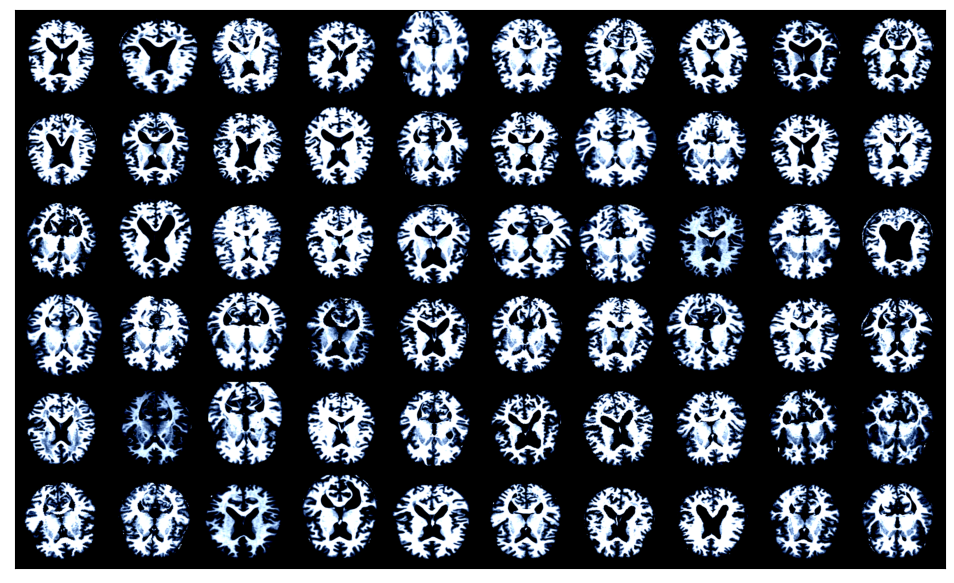

In [13]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:60], nrow=10).permute(1, 2, 0))
        break
        
show_batch(train_dl)

# Definition of the ResNet50-based Classification Model

This code block defines a PyTorch module for a ResNet50-based classification model. The ResNet50 model is loaded with pre-trained weights and the output layer is modified to classify into four different classes. The class is defined with a dropout parameter, which controls the probability of setting input elements to zero during training.

The forward method is implemented to pass the input tensor through the model and return the output. This model can be used for image classification tasks, where the input is a 3-channel RGB image and the output is one of the four classes defined in the output layer.

In [32]:
class Model(nn.Module):
    def __init__(self, dropout=0.2):
        super(Model, self).__init__()
        
        model = torchvision.models.resnet50(pretrained=True)
        
        num_ftrs = model.fc.in_features
            
        for param in model.fc.parameters():
            param.require_grad = False
            
        # Modify the output layer to have 4 labels
        model.fc = torch.nn.Sequential(
            torch.nn.Dropout(dropout, inplace=True),
            torch.nn.Linear(num_ftrs,4),
        )
        
        self.model = model
    
    def forward(self, x):
        out = self.model(x)
        return out


# Training Function
This code defines a train function that is used to train a PyTorch model using a specified optimizer, learning rate scheduler, loss criterion, and data loaders for training and validation sets. The function takes the following parameters:

`model`: A PyTorch model to be trained.

`train_loader`: A PyTorch data loader for the training set.

`test_loader`: A PyTorch data loader for the validation set. If this is an empty list, the function will not evaluate the model on a validation set.

`optimizer`: A PyTorch optimizer object to use for training the model.

`scheduler`: A PyTorch learning rate scheduler object to adjust the learning rate during training.

`criterion`: A PyTorch loss criterion object to calculate the loss.

`epochs`: The number of epochs to train the model.

`save_path`: A file path to save the model if the validation loss improves.
Inside the function, the data is loaded onto the device specified by the available hardware. Then, the function trains the model over the specified number of epochs. For each epoch, it calculates the training loss and accuracy, and if a validation set is provided, it calculates the validation loss and accuracy as well. The function also saves the model if the validation loss improves during training.

Finally, the function returns the trained model and the training and validation loss and accuracy lists.

In [20]:
def train(model, train_loader, test_loader, optimizer, scheduler, criterion, epochs, save_path):
    # Define the device to use for training
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # Initialize lists to store the training and validation loss and accuracy
    losses = {'train': [], 'val': []}
    accuracies = {'train': [], 'val': []}
    
    # Move the model to the device
    model.to(device)
    
    # Initialize the best validation loss to infinity
    best_val_loss = float('inf')

    # Loop over the specified number of epochs
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        model.train()
        
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data

            # Move the inputs and labels to the device
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()

            running_loss += loss.item()
            
            # Calculate the training accuracy
            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()
                
        # Calculate the average training loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        # Append the training loss and accuracy to their respective lists
        losses['train'].append(train_loss)
        accuracies['train'].append(train_acc)
        
        if len(test_loader) > 0:    
            # Evaluate the model on the validation set after each epoch
            correct_val = 0
            total_val = 0
            running_loss_val = 0.0

            model.eval()

            with torch.no_grad():
                for data in test_loader:
                    images, labels = data
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    running_loss_val += loss.item()

                    # Calculate the validation accuracy
                    _, predicted_val = torch.max(outputs.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted_val == labels).sum().item()

            # Calculate the average validation loss and accuracy
            val_loss = running_loss_val / len(test_loader)
            val_acc = 100 * correct_val / total_val

            # Append the validation loss and accuracy to their respective lists
            losses['val'].append(val_loss)
            accuracies['val'].append(val_acc)
            
            # Save the model if the validation loss improves
            if save_path is not None and val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), save_path)
                print('Model saved at epoch', epoch + 1)

            # Print the loss and accuracy for the current epoch
            print('Epoch %d - Train Loss: %.2f - Train Acc: %.2f %% - Val Loss: %.3f - Val Acc: %.2f %%'
                  % (epoch + 1, train_loss, train_acc, val_loss, val_acc))
        else:
            print('Epoch %d - Train Loss: %.2f - Train Acc: %.2f %%'
                  % (epoch + 1, train_loss, train_acc))
        
        
        scheduler.step()
            
    print('Finished Training')

    # Return the training and validation loss and accuracy lists
    return model, losses, accuracies

This part of the code is training a neural network model using the Adam optimizer and cross-entropy loss function. The scheduler used here is a step learning rate scheduler, which reduces the learning rate by a factor of gamma after every step_size epochs. The training process is carried out for 12 epochs.

The train function is called to train the model, which takes the model, train data loader, validation data loader, optimizer, scheduler, criterion, number of epochs, and model checkpoint filename as input. It returns the trained model, losses, and accuracies for each epoch.

During the training process, the model is evaluated on both the training and validation sets for each epoch, and the corresponding losses and accuracies are printed. If the model's performance on the validation set improves, it is saved as a checkpoint. At the end of training, the function returns the final model, losses, and accuracies.

In [16]:
model = Model(0)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=4,gamma=0.1)

epochs = 12

model, losses, accuracies = train(model, train_dl, val_dl, optimizer, scheduler, criterion, epochs, 'alzheimer.pt')

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 - Train Loss: 0.34 - Train Acc: 86.32 % - Val Loss: 0.184 - Val Acc: 93.05 %
Model saved at epoch 1
Epoch 2 - Train Loss: 0.05 - Train Acc: 98.36 % - Val Loss: 0.139 - Val Acc: 95.16 %
Model saved at epoch 2
Epoch 3 - Train Loss: 0.04 - Train Acc: 98.77 % - Val Loss: 0.059 - Val Acc: 97.97 %
Model saved at epoch 3
Epoch 4 - Train Loss: 0.04 - Train Acc: 98.79 % - Val Loss: 0.113 - Val Acc: 96.02 %
Epoch 5 - Train Loss: 0.01 - Train Acc: 99.80 % - Val Loss: 0.016 - Val Acc: 99.51 %
Model saved at epoch 5
Epoch 6 - Train Loss: 0.00 - Train Acc: 99.99 % - Val Loss: 0.014 - Val Acc: 99.61 %
Model saved at epoch 6
Epoch 7 - Train Loss: 0.00 - Train Acc: 99.98 % - Val Loss: 0.012 - Val Acc: 99.67 %
Model saved at epoch 7
Epoch 8 - Train Loss: 0.00 - Train Acc: 100.00 % - Val Loss: 0.012 - Val Acc: 99.69 %
Model saved at epoch 8
Epoch 9 - Train Loss: 0.00 - Train Acc: 100.00 % - Val Loss: 0.012 - Val Acc: 99.69 %
Epoch 10 - Train Loss: 0.00 - Train Acc: 100.00 % - Val Loss: 0.011 - Va

These are two sets of code that plot the training and validation loss and accuracy over epochs using Matplotlib library.

The first plot shows the training and validation loss over the number of epochs. It creates two lines, one for training loss and the other for validation loss, where the x-axis is the number of epochs and the y-axis is the loss. The "legend" function is used to differentiate between the two lines, and the "title", "xlabel" and "ylabel" functions are used to label the plot appropriately. Finally, the plot is displayed using the "show" function.

The second plot shows the training and validation accuracy over epochs. It creates two lines, one for training accuracy and the other for validation accuracy, where the x-axis is the number of epochs and the y-axis is the accuracy. The "legend" function is used to differentiate between the two lines, and the "title", "xlabel" and "ylabel" functions are used to label the plot appropriately. Finally, the plot is displayed using the "show" function. However, there is a mistake in the legend of this plot as it shows "Train acc" for both lines, which should be corrected.

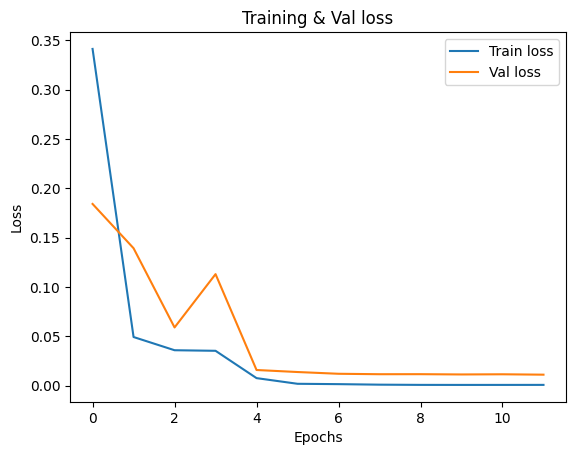

In [17]:
plt.plot(range(0, epochs), losses['train'], label="Train loss")
plt.plot(range(0, epochs), losses['val'], label="Val loss")
plt.title('Training & Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

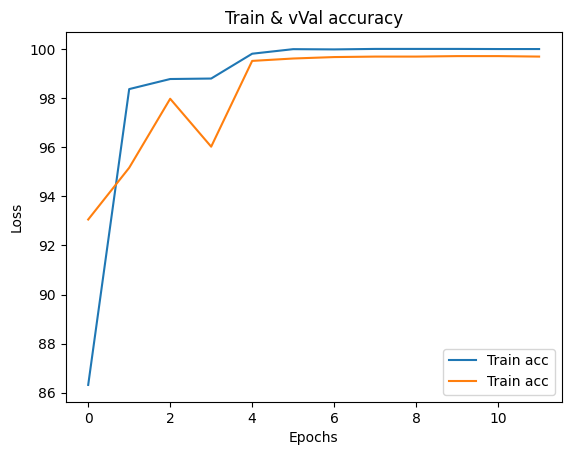

In [18]:
plt.plot(range(0, epochs), accuracies['train'], label="Train acc")
plt.plot(range(0, epochs), accuracies['val'], label="Train acc")
plt.title('Train & vVal accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

This code is similar to the previous code, but there are a few differences:

The ConcatDataset is created by combining train_ds1 and val_ds1, instead of just using train_ds1.
The second argument to train is an empty list ([]) instead of val_dl. This means that the model won't be evaluated on a validation set during training.
The saved model filename is still alzheimer.pt.

In [33]:
train_dl = DataLoader(ConcatDataset([
    train_ds1,
    val_ds1,
]), BATCH_SIZE, shuffle=True)

model = Model(0)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=4,gamma=0.1)

epochs = 12

model, losses, accuracies = train(model, train_dl, [], optimizer, scheduler, criterion, epochs, 'alzheimer.pt')

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch 1 - Train Loss: 0.30 - Train Acc: 87.69 %
Epoch 2 - Train Loss: 0.06 - Train Acc: 98.09 %
Epoch 3 - Train Loss: 0.02 - Train Acc: 99.22 %
Epoch 4 - Train Loss: 0.03 - Train Acc: 99.18 %
Epoch 5 - Train Loss: 0.00 - Train Acc: 99.89 %
Epoch 6 - Train Loss: 0.00 - Train Acc: 99.98 %
Epoch 7 - Train Loss: 0.00 - Train Acc: 100.00 %
Epoch 8 - Train Loss: 0.00 - Train Acc: 100.00 %
Epoch 9 - Train Loss: 0.00 - Train Acc: 100.00 %
Epoch 10 - Train Loss: 0.00 - Train Acc: 100.00 %
Epoch 11 - Train Loss: 0.00 - Train Acc: 100.00 %
Epoch 12 - Train Loss: 0.00 - Train Acc: 100.00 %
Finished Training


# Tests

In [ ]:
# Load the saved model checkpoint
checkpoint = torch.load('alzheimer.pt')

# Create a new model instance
model = Model(0)

# Load the saved weights into the model
model.load_state_dict(checkpoint)

/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


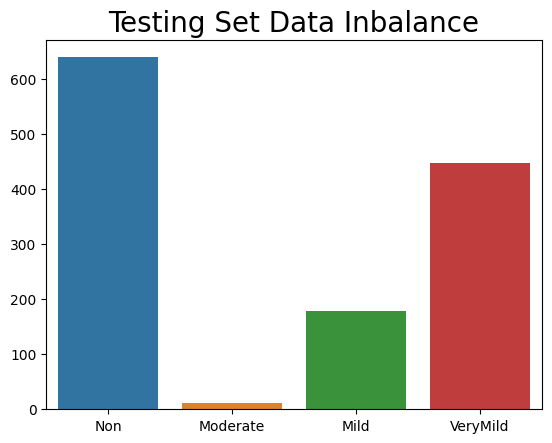

In [22]:
test_samplesize = pd.DataFrame.from_dict({
    'Non': [len([os.path.join(ALZHEIMER_DATA + '/test/NonDemented', filename) for filename in
                 os.listdir(ALZHEIMER_DATA + '/test/NonDemented')])],
    'Moderate': [len([os.path.join(ALZHEIMER_DATA + '/test/ModerateDemented', filename) for filename in
                      os.listdir(ALZHEIMER_DATA + '/test/ModerateDemented')])],
    'Mild': [len([os.path.join(ALZHEIMER_DATA + '/test/MildDemented', filename) for filename in
                  os.listdir(ALZHEIMER_DATA + '/test/MildDemented')])],
    'VeryMild': [len([os.path.join(ALZHEIMER_DATA + '/test/VeryMildDemented', filename) for filename in
                      os.listdir(ALZHEIMER_DATA + '/test/VeryMildDemented')])],
})

sns.barplot(data=test_samplesize).set_title('Testing Set Data Inbalance', fontsize=20)
plt.show()

In [23]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

In [24]:
def validation_step(batch):
        images, labels = batch
        images, labels = images.to(device),labels.to(device)
        out = model(images)
        loss = nn.functional.cross_entropy(out, labels)
        acc,preds = accuracy(out, labels)

        return {
            'val_loss': loss.detach(),
            'val_acc': acc.detach(),
            'preds': preds.detach(),
            'labels': labels.detach()
        }

In [25]:
def test_prediction(outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()           
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()             
        # combine predictions
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()] 
        # combine labels
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]  
        
        return {
            'test_loss': epoch_loss.item(),
            'test_acc': epoch_acc.item(),
            'test_preds': batch_preds,
            'test_labels': batch_labels
        }

In [26]:
@torch.no_grad()
def test_predict(model, test_loader):
    # perform testing for each batch
    outputs = [validation_step(batch) for batch in test_loader] 
    results = test_prediction(outputs)                          
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))
    
    return results['test_preds'], results['test_labels']

In [27]:
test_dataset = ImageFolder(ALZHEIMER_DATA+'/test', 
                           transform.Compose([
        transform.Resize((224,224)),
        transform.ToTensor(),
        transform.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]))

In [28]:
test_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE)
model.to(device)
model.eval()
preds,labels = test_predict(model, test_dl)

test_loss: 0.6903, test_acc: 0.8178


# Calculation of some more metrics and visualization of predictions

<Figure size 640x480 with 0 Axes>

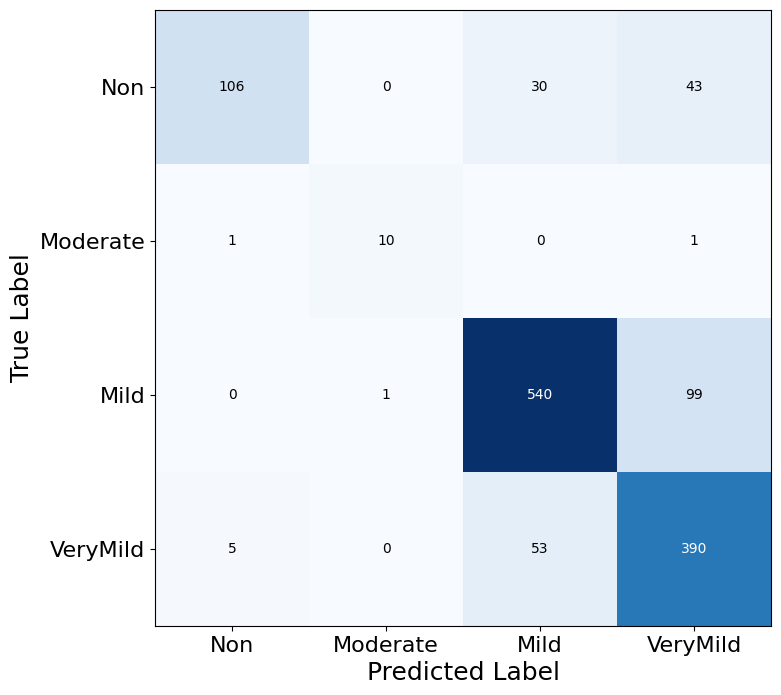

In [29]:
cm  = confusion_matrix(labels, preds)

plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(4), ['Non', 'Moderate', 'Mild', 'VeryMild'], fontsize=16)
plt.yticks(range(4), ['Non', 'Moderate', 'Mild', 'VeryMild'], fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

In [ ]:
# select 5 normal and 5 pneumonia images indices
idxs = torch.tensor(np.append(np.arange(start=0, stop=5, step=1), 
                             np.arange(start=500, stop=505, step=1))) 

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,14))

for c,i in enumerate(idxs):
    img_tensor, label = test_dataset[i]
    ax[c//5][c%5].imshow(img_tensor[0,:,:], cmap='gray')
    ax[c//5][c%5].set_title('Label: {}\nPrediction: {}'
                            .format(test_dataset.classes[label], 
                                    test_dataset.classes[preds[i]]),
                            fontsize=25)
    ax[c//5][c%5].axis('off')